In [1]:
"""
The OS module in Python provides a way of using operating system dependent functionality.
"""
import os
import urllib.request
from typing import List, Optional, Union
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


class Agros:
    """
    A class for downloading and processing agricultural data.
    """

    def __init__(self):
        """
        Initializes the Agros class.
        """
        self.url = (
            "https://raw.githubusercontent.com/owid/owid-datasets/master/datasets/"
            "Agricultural%20total%20factor%20productivity%20(USDA)/"
            "Agricultural%20total%20factor%20productivity%20(USDA).csv"
        )
        self.filename = "Agricultural total factor productivity (USDA).csv"
        self.download_dir = os.path.join(os.getcwd(), "downloads")
        self.download_path = os.path.join(self.download_dir, self.filename)
        self.dataset = None

    def download_data(self):
        """
        Downloads data from a given URL and saves it to a specified file path.

        Returns
        -------
            pandas.DataFrame: The downloaded dataset.
        """
        if os.path.isfile(self.download_path):
            print("Data file already exists, skipping download...")
            self.dataset = pd.read_csv(
                "downloads/Agricultural total factor productivity (USDA).csv"
            )
            return self.dataset

        if not os.path.exists(self.download_dir):
            os.makedirs(self.download_dir)
            print(f"Created directory: {self.download_dir}")

        print(f"Downloading data file from {self.url}...")
        urllib.request.urlretrieve(self.url, self.download_path)

        print(f"Data file downloaded and saved to {self.download_path}")
        self.dataset = pd.read_csv(
            "downloads/Agricultural total factor productivity (USDA).csv"
        )
        return self.dataset

    def get_countries(self):
        """
        Returns a list of available countries in the dataset.

        Returns
        -------
        list
            A list of strings representing the available countries in the dataset.
        """
        if self.dataset is None:
            self.download_data()

        return list(self.dataset["Entity"].unique())

    def plot_correlation(self) -> None:

        """
        Plots a heatmap of the correlations between the specified columns.

        Parameters
        ----------
        columns : list of str
            A list of strings representing the columns to include in the correlation analysis.

        Returns
        -------
        None
            This function has no return value.
        """
        # load data
        if self.dataset is None:
            self.download_data()

        data_frame = self.dataset.filter(regex="_quantity")
        corr = data_frame.corr()
        sns.heatmap(corr, cmap="coolwarm", annot=True)

    def areachart_country_output(
        self, country: Optional[str] = "World", normalize: bool = False
    ) -> None:

        """
        Plots an area chart of the  "_output_" columns for a given country

        Parameters
        ---------------
        country: string
            Country selected to plot area chart of the outputs, if *NONE* or
            'World' should plot the sum for all *distinct* countries
        normalize: boolean
            If True, normalizes the output in relative terms: each year, output
             should always be 100%

        Raises
        -------
            ValueError(f'{country} is not a valid')

        Returns
        -------
            Area Chart: This function returns area chart with outputs of a country by year

        """

        # Load data
        if self.dataset is None:
            self.download_data()

        data_frame = self.dataset.filter(regex="_output_|Year|Entity")

        # Filter by country if specified
        if country is not None:
            if country.lower() == "world" or country is None:
                data_frame = data_frame.groupby("Year").sum().reset_index()
            else:
                data_frame = data_frame[data_frame["Entity"] == country.capitalize()]
                if data_frame.empty:
                    raise ValueError(f"Country '{country}' not found in dataset.")
                data_frame = data_frame.drop("Entity", axis=1)

        # Normalize if specified
        if normalize:
            data_frame.iloc[:, 1:] = (
                data_frame.iloc[:, 1:]
                .div(data_frame.iloc[:, 1:].sum(axis=1), axis=0)
                .multiply(100)
            )

        # Plot an area chart for the output columns
        sns.set_theme(palette="bright")
        plt.stackplot(
            data_frame["Year"],
            data_frame.iloc[:, 1:].values.T,
            labels=data_frame.iloc[:, 1:].columns,
        )
        plt.legend()
        plt.xlabel("Year")
        plt.title(
            f'Agricultural Outputs {"for " + country if country else "All Countries"}'
        )
        plt.show()

    def plot_country_output(self, countries: Union[str, List[str]] = "World") -> None:

        """
        Plots the total output of one or more countries over time.

        Parameters
        ----------
        countries : str or list of str
            The name(s) of the country(ies) to plot.

        Returns
        -------
        None
        """

        # load data
        if self.dataset is None:
            self.download_data()

        data_frame = self.dataset

        if isinstance(countries, str):
            countries = [countries]

        # check if all specified countries are in dataset
        for country in countries:
            if country not in data_frame["Entity"].unique():
                raise ValueError(f"Country '{country}' not found in dataset.")

        # plot data
        fig, ax_plot = plt.subplots()
        for country in countries:
            country_data = data_frame[data_frame["Entity"] == country]
            ax_plot.plot(country_data["Year"], country_data["output"], label=country)

        ax_plot.legend()
        ax_plot.set_xlabel("Year")
        ax_plot.set_ylabel("Output")
        ax_plot.set_title("Comparison of Total Output by Country")

        plt.show()

    def gapminder(self, year: int) -> None:

        """
        Creates a scatter plot of fertilizer quantity vs. output quantity
        for a specific year in the Gapminder dataset, where the area of each
        dot represents the TFP (total factor productivity) for the respective year.

        Parameters
        ----------
        year : int
            The year for which to create the scatter plot.

        Raises
        ------
        TypeError
            If the year argument is not an integer.

        Returns
        -------
        None

        Notes
        -----
        This method assumes that the dataset has already been downloaded and loaded
        into a pandas DataFrame with columns "Year", "fertilizer_quantity", "output_quantity",
        and "tfp". If these columns are not present, an error will be raised.
        """

        if self.dataset is None:
            self.download_data()

        # Check that the year argument is an int
        if not isinstance(year, int):
            raise TypeError("Year argument must be an integer.")

        # Load the gapminder dataset into a pandas DataFrame
        data_frame = self.dataset

        # Filter the DataFrame to include only the selected year
        data_frame_year = data_frame[data_frame["Year"] == year]

        # Create a scatter plot of fertilizer quantity vs. output quantity
        plt.scatter(
            data_frame_year["fertilizer_quantity"],
            data_frame_year["output_quantity"],
            s=data_frame_year["tfp"],
        )
        plt.xlabel("Fertilizer quantity")
        plt.ylabel("Output quantity")
        plt.xscale("log")
        plt.yscale("log")
        plt.title("Evolvement of TFP for the year {}".format(year))
        plt.show()


The class and methods developed with the Agricultural Output Productivity dataset has allowed us to extract valuable insights. The development of the task and the study of the agricultural outputs of several countries will help to contribute to the green transition by having a more savvy taskforce. The main insights were the following:

The graph below shows the evolvement of the TFP for the most recent yer, 2019. As can be portrayed, the world's output quantity and fertilizer quantity are linnearly correlated. That is to say, that globally, the more fertilizer's used for production, the more outputs are generated. 

Data file already exists, skipping download...


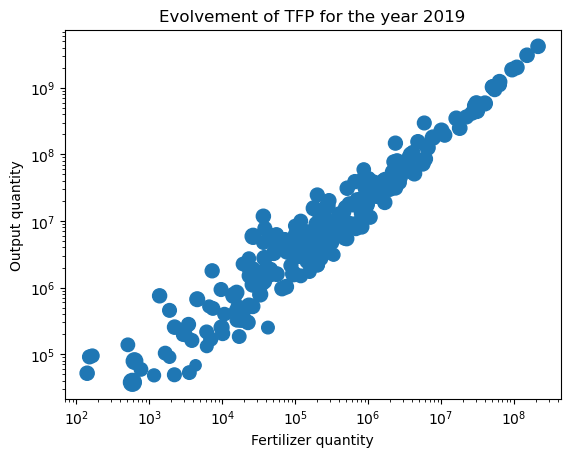

In [6]:
agros = Agros()
agros.gapminder(2019)

Three random countries in the dataset (one from each continent) were selected to ilustrate and point out the main differences from our analysis. 

The fourth method was created to plots the crop, animal and fish outputs for a given country. Below, the comparison of the three outputs for Brazil, Portugal and Afghanistan can be visualized. 

The main similarity betweeen the three countries is that they all have a minimal insignificant fish_output_quantity. Moreover, the crop and animal output quantity for the three countries follow a similar trend through time. That is to say, when crop outuput increases, so does the animal output for a given country and viceversa. 

The main differences that can be spotted are that each country follows different outputs trough time. Portugal shows a more constant production whereas Afghansitan and Brazil show a more gradual increase through time.

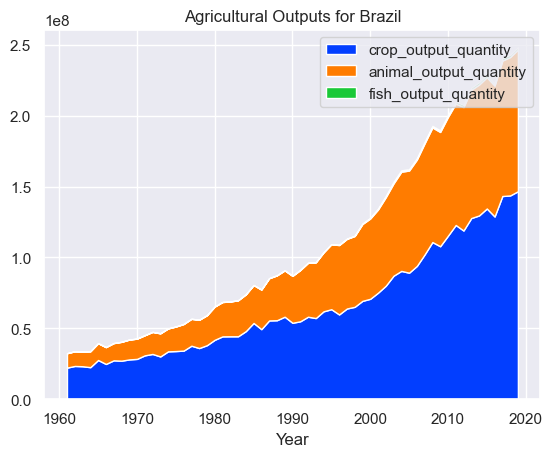

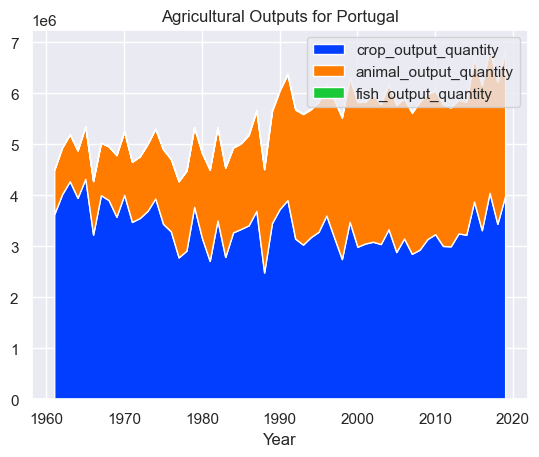

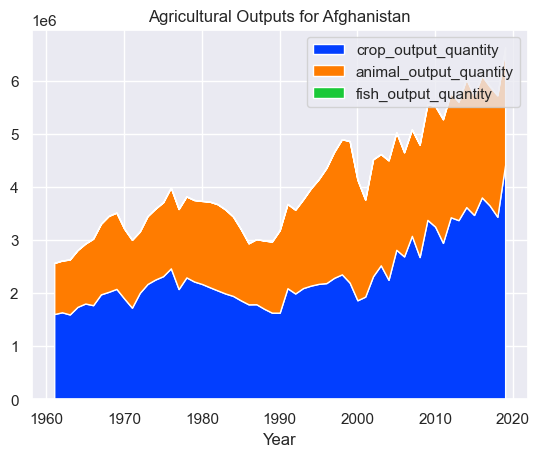

In [19]:
three_countries=["Brazil","Portugal","Afghanistan"]

for i in range(0,len(three_countries)):
    agros.areachart_country_output(three_countries[i])
    i=i+1

The fifth method was used to illustrate the compare of total output for Brazil, Portugal and Afghanistan for each Year. As can be portrayed in the graph below, the three countries have reached similar output quantity level throughout the last decade. However, from 1960-2010, the european country, Portugal, has had a clear advantage over Brazil and Afghanistan. The evolution of output production from Portugal has been more steady and gradual. On the contrary, Brazil has vastly increased its output througout the years analysed and has had a constant increase. In the case of Afghanistan, the country shows the highest agricultural output for the last decade. The method carried out is very useful to compare different countries outputs throghout time and obtain useful insights. 

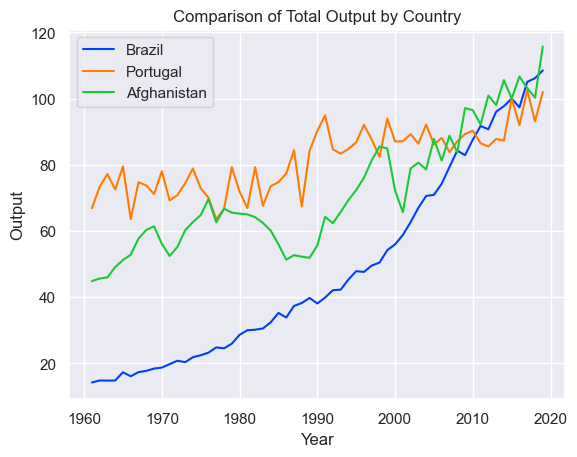

In [20]:
agros.plot_country_output(three_countries)

The third method developed shows a correlation plot that allows us to visualize how variables correlate with each other. As can be visualized below, all variables have a strong correlation wih eachother, all above 0.5. The only variables that have a weaker correlation with the other variables are the fish_output_quantity and the labor_output_quantity.

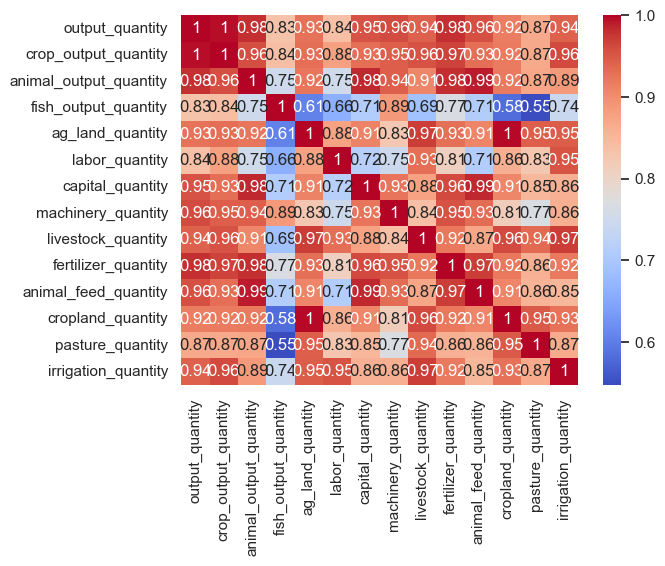

In [21]:
agros.plot_correlation()

Overall, the class and methods created for the analysis of Agricultural outputs between countries has allowed us to obtain valuable insights between quantities and outputs to contribute to the green transition by having a more savvy taskforce. 